In [1]:
import jax
import jax.numpy as jnp
from typing import NamedTuple, Callable, Optional
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from functools import cache

In [2]:
DIRECTIONS = jnp.array([(1, 0), (0, 1), (-1, 0), (0, -1)])
ND = len(DIRECTIONS)
RIGHT, UP, LEFT, DOWN = range(ND)  # in clockwise order

Position = jnp.ndarray  # (x, y)
TileType = int  # index into the tileset

# Constructing the Tileset

In [3]:
class Tileset(NamedTuple):
    tiles: pd.DataFrame
    neighbors: pd.DataFrame
    subsets: pd.DataFrame

def load_tileset(path: str) -> Tileset:
    groups = ['tiles', 'neighbors', 'subsets']
    tiles, neighbors, subsets = [pd.read_xml(path, xpath=f'./{group}/*') for group in groups]
    subsets = {name: pd.read_xml(path, xpath=f'./subsets/subset[@name="{name}"]/*') for name in subsets['name']}
    return Tileset(tiles, neighbors, subsets)

In [4]:
circuit_tiles = load_tileset('./tilesets/Circuit.xml')
circuit_tiles.tiles

,name,symmetry,weight
0,bridge,I,1.0
1,component,X,20.0
2,connection,T,10.0
3,corner,L,10.0
4,substrate,X,2.0
5,t,T,0.1
6,track,I,2.0
7,transition,T,0.4
8,turn,L,1.0
9,viad,I,0.1


## Tile rotations

I'll use "tile" to refer to the original, unrotated tiles, and "TILE" to refer to an element of the massive set of rotated tiles we obtain afterwards.

$C$ denotes the number of TILEs.

In [5]:
class Symmetry(NamedTuple):
    card: int
    """The number of elements in the symmetry group."""

    rotate: Callable[[int], int]
    """A function that rotates an element of the symmetry group."""

    flip: Callable[[int], int]
    """A function that flips an element of the symmetry group."""

id = lambda i: i
rotate = lambda i: (i + 1) % 4                     # rotates clockwise                         (1, 2, 3, 0)
flipa = lambda i: i ^ 1                            # flips across the diagonal y=x             (2, 3, 0, 1)
flipb = lambda i: jnp.where(i % 2 == 0, i, 4 - i)  # flips across the x-axis                   (3, 0, 1, 2)
flipc = lambda i: 1 - i                            # same as flipa but using negative indices  (1, 0, -1, -2)

SYMMETRIES = {
    'X': Symmetry(1, id, id),
    'L': Symmetry(4, rotate, flipa),
    'T': Symmetry(4, rotate, flipb),
    'I': Symmetry(2, flipc, id),
    '\\': Symmetry(2, flipc, flipc),
    'F': Symmetry(8, lambda i: jnp.where(i < 4, rotate(i), 4 + rotate(i)), lambda i: i ^ 4),
}

def _get_symmetry(sym: Symmetry, t=0):
    s = []
    for _ in range(4):
        s.append((t, sym.flip(t)))
        t = sym.rotate(t)
    return jnp.array(s)

@cache
def get_symmetries(symmetry: str) -> list[Symmetry]:
    s = SYMMETRIES[symmetry]
    return jax.vmap(_get_symmetry, in_axes=(None, 0))(s, jnp.arange(s.card))

In [6]:
def show_symmetries(tile: str, symmetry: str):
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    img = plt.imread(f'./tilesets/Circuit/{tile}.png')
    axs[0, 0].imshow(img)
    axs[0, 0].axis('off')
    axs[0, 0].set_title(f"{tile} ({symmetry})")

    axs[1, 0].axis('off')

    for j, k in enumerate(_get_symmetry(SYMMETRIES[symmetry])):
        i = j + 1
        k0, k1 = k[0].item(), k[1].item()
        axs[0, i].imshow(jnp.rot90(img, k0))
        axs[1, i].imshow(jnp.rot90(img, k1))
        axs[0, i].axis('off')
        axs[1, i].axis('off')
        axs[0, i].set_title(k0)
        axs[1, i].set_title(k1)
    plt.show()

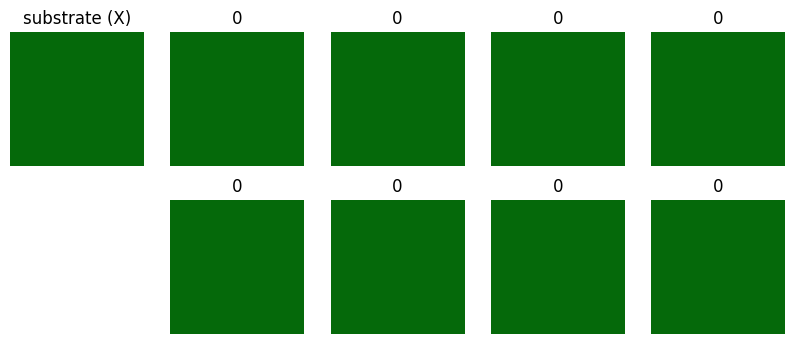

In [7]:
show_symmetries('substrate', 'X')

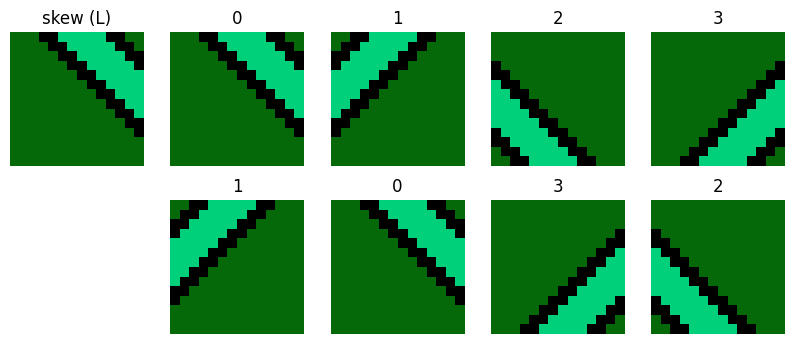

In [8]:
show_symmetries('skew', 'L')

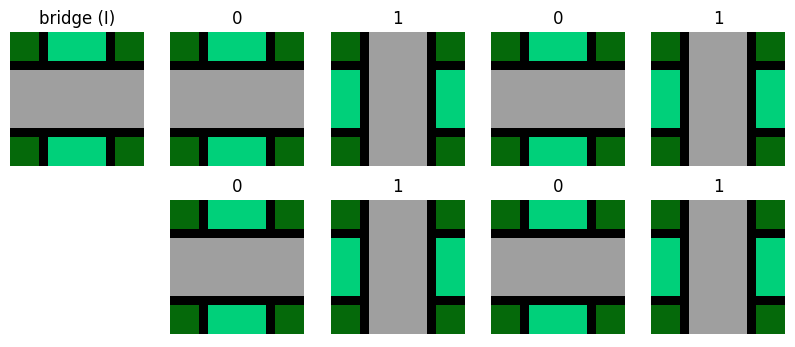

In [9]:
show_symmetries('bridge', 'I')

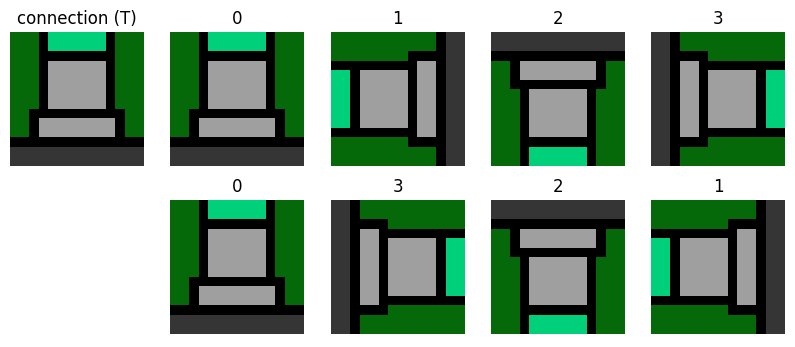

In [10]:
show_symmetries('connection', 'T')

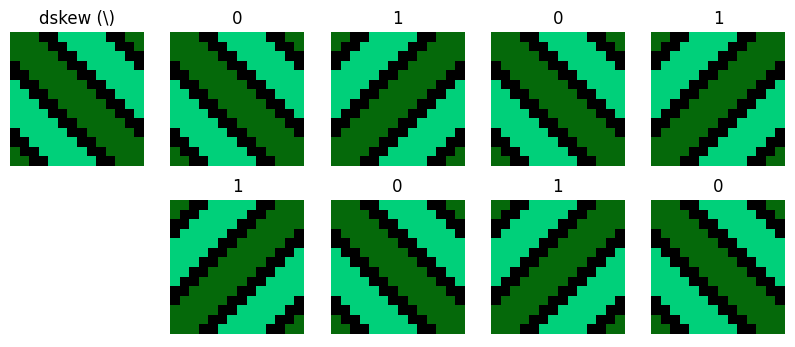

In [11]:
show_symmetries('dskew', '\\')

In [12]:
def load_patterns(tiles: Tileset):
    """
    Turns the set of tiles into the set of TILEs.
    """
    names = []
    spins = []
    stepsto = []
    weights = []

    for name, symmetry, weight in tiles.tiles.itertuples(index=False):
        s = get_symmetries(symmetry)  # Shape (sym.card, 4, 2)
        card = s.shape[0]
        names.extend([name] * card)
        spins.extend(range(card))
        stepsto.extend(s + len(stepsto))
        weights.extend([weight] * card)

    index = pd.MultiIndex.from_arrays([names, spins], names=['name', 'spin'])
    return pd.DataFrame({
        'stepsto': stepsto,
        'weight': weights,
    }, index=index)

In [13]:
patterns = load_patterns(circuit_tiles)
patterns

stepsto  weight
name       spin                                                  
bridge     0             [[0, 0], [1, 1], [0, 0], [1, 1]]     1.0
           1             [[1, 1], [0, 0], [1, 1], [0, 0]]     1.0
component  0             [[2, 2], [2, 2], [2, 2], [2, 2]]    20.0
connection 0             [[3, 3], [4, 6], [5, 5], [6, 4]]    10.0
           1             [[4, 6], [5, 5], [6, 4], [3, 3]]    10.0
           2             [[5, 5], [6, 4], [3, 3], [4, 6]]    10.0
           3             [[6, 4], [3, 3], [4, 6], [5, 5]]    10.0
corner     0           [[7, 8], [8, 7], [9, 10], [10, 9]]    10.0
           1           [[8, 7], [9, 10], [10, 9], [7, 8]]    10.0
           2           [[9, 10], [10, 9], [7, 8], [8, 7]]    10.0
           3           [[10, 9], [7, 8], [8, 7], [9, 10]]    10.0
substrate  0     [[11, 11], [11, 11], [11, 11], [11, 11]]     2.0
t          0     [[12, 12], [13, 15], [14, 14], [15, 13]]     0.1
           1     [[13, 15], [14, 14], [15, 13], [12, 12]]     0.1
           2     [[14, 14], [15, 13], [12, 12], [13, 15]]     0.1
           3     [[15, 13], [12, 12], [13, 15], [14, 14]]     0.1
track      0     [[16, 16], [17, 17], [16, 16], [17, 17]]     2.0
           1     [[17, 17], [16, 16], [17, 17], [16, 16]]     2.0
transition 0     [[18, 18], [19, 21], [20, 20], [21, 19]]     0.4
           1     [[19, 21], [20, 20], [21, 19], [18, 18]]     0.4
           2     [[20, 20], [21, 19], [18, 18], [19, 21]]     0.4
           3     [[21, 19], [18, 18], [19, 21], [20, 20]]     0.4
turn       0     [[22, 23], [23, 22], [24, 25], [25, 24]]     1.0
           1     [[23, 22], [24, 25], [25, 24], [22, 23]]     1.0
           2     [[24, 25], [25, 24], [22, 23], [23, 22]]     1.0
           3     [[25, 24], [22, 23], [23, 22], [24, 25]]     1.0
viad       0     [[26, 26], [27, 27], [26, 26], [27, 27]]     0.1
           1     [[27, 27], [26, 26], [27, 27], [26, 26]]     0.1
vias       0     [[28, 28], [29, 31], [30, 30], [31, 29]]     0.3
           1     [[29, 31], [30, 30], [31, 29], [28, 28]]     0.3
           2     [[30, 30], [31, 29], [28, 28], [29, 31]]     0.3
           3     [[31, 29], [28, 28], [29, 31], [30, 30]]     0.3
wire       0     [[32, 32], [33, 33], [32, 32], [33, 33]]     0.5
           1     [[33, 33], [32, 32], [33, 33], [32, 32]]     0.5
skew       0     [[34, 35], [35, 34], [36, 37], [37, 36]]     2.0
           1     [[35, 34], [36, 37], [37, 36], [34, 35]]     2.0
           2     [[36, 37], [37, 36], [34, 35], [35, 34]]     2.0
           3     [[37, 36], [34, 35], [35, 34], [36, 37]]     2.0
dskew      0     [[38, 39], [39, 38], [38, 39], [39, 38]]     2.0
           1     [[39, 38], [38, 39], [39, 38], [38, 39]]     2.0

# Propagation

Great! Now that we have the set of rotations set up,
we need to be able to tell which tile types are allowed to be
next to each other. We'll do this with a `propagator` matrix defined below.

In [14]:
def _preprocess(left, right):
    """Turn a name in the 'neighbors' table into a (name, spin) pair for indexing into the df."""
    left, right = left.split(' '), right.split(' ')
    if len(left) == 1:
        left += ['0']
    if len(right) == 1:
        right += ['0']
    return (left[0], int(left[1])), (right[0], int(right[1]))

def create_propagator(tileset: Tileset, stepsto: pd.DataFrame) -> jnp.ndarray:
    """Shape (D, C, C). propagator[dir, from, to] is True if
    the tile `from` is compatible with tile `to` in direction `dir`.
    For example, propagator[RIGHT, L, R] means that the tile pattern L -> R is allowed."""

    # use regular numpy temporarily since it's more convenient
    propagator = np.empty((ND, len(stepsto), len(stepsto)), dtype=np.bool_)

    for pair in tqdm(tileset.neighbors.itertuples(index=False), total=len(tileset.neighbors)):
        l, r = _preprocess(*pair)
        lstep, rstep = stepsto.loc[[l, r], 'stepsto']
        dstep = stepsto.iloc[lstep[1, 0].item()]['stepsto']
        ustep = stepsto.iloc[rstep[1, 0].item()]['stepsto']

        propagator[LEFT, rstep[0, 0], lstep[0, 0]] = True
        propagator[LEFT, lstep[0, 1], rstep[0, 1]] = True
        propagator[LEFT, lstep[2, 0], rstep[2, 0]] = True
        propagator[LEFT, rstep[2, 1], lstep[2, 1]] = True

        propagator[UP, ustep[0, 0], dstep[0, 0]] = True
        propagator[UP, dstep[0, 1], ustep[0, 1]] = True
        propagator[UP, ustep[2, 1], dstep[2, 1]] = True
        propagator[UP, dstep[2, 0], ustep[2, 0]] = True
    
    propagator[RIGHT] = propagator[LEFT].T
    propagator[DOWN] = propagator[UP].T

    return jnp.array(propagator)

In [15]:
propagator = create_propagator(circuit_tiles, patterns)
propagator.shape

100%|██████████| 145/145 [00:06<00:00, 23.89it/s]


(4, 40, 40)

# State

Now let's build the actual algorithm for "collapsing the wave function"!
The "wave function" itself is a boolean array. For each (node, tile type) pair,
it tracks whether or not this pair is still valid.

In [16]:
class State(NamedTuple):
    """The state of the WFC algorithm."""

    wave: jnp.ndarray
    """Shape (W, H, C). wave[x, y, k] is True if pattern k is possible at
    position (x, y), and False otherwise."""

    compatible: jnp.ndarray
    """Shape (W, H, D, C). compatible[x, y, d, k] counts how many ways there are to get
    type k at position (x, y) _from_ direction d."""

    entropies: jnp.ndarray
    """Shape (W, H). The entropy of each position. Used for picking the next state."""

    def ntypes(self):
        return self.wave.shape[-1]
    
    def shape(self):
        return self.wave.shape[:2]
    
    def positions(self):
        w, h = self.shape()
        return jnp.mgrid[:w, :h].reshape(2, -1).T
    
    def counts(self):
        return self.wave.sum(axis=-1)
    
    def is_collapsed(self):
        """Shape (W, H). True if the wave is collapsed at the given position."""
        return self.counts() == 1
    
class Problem(NamedTuple):
    """The problem to be solved by the WFC algorithm."""

    weights: jnp.ndarray
    """The marginal unnormalized positive probability assigned to each pattern."""

    propagator: jnp.ndarray
    """Shape (D, C, C). propagator[dir, from, to] is True if the tile `from` is
    compatible with tile `to` in direction `dir`."""

In [17]:
def init_state(problem: Problem, W: int, H: int) -> State:
    """Initializes the state of the WFC algorithm."""
    C = problem.weights.shape[0]
    wave = jnp.ones((W, H, C), dtype=jnp.bool_)
    entropies = jnp.full((W, H), entropy(problem.weights))
    # TODO make sure to generalize this for arbitrary directions
    counts = problem.propagator.sum(axis=-1)  # (D, C) how many tiles does each tile connect to (in that direction)?
    compatible = jnp.broadcast_to(counts[jnp.arange(ND) ^ 2], (W, H, ND, C))
    return State(wave, compatible, entropies)

@jax.jit
def entropy(weights: jnp.ndarray):
    """Weights should be the unnormalized positive probability of each tile type.
    Not to be confused with logits = log(weights)."""
    s = jnp.sum(weights, axis=-1)
    w = jnp.where(weights > 0, weights * jnp.log(weights), 0)  # avoid log zero errors
    return jnp.log(s) - jnp.sum(w, axis=-1) / s

In [18]:
problem = Problem(patterns['weight'].values, propagator)
state = init_state(problem, 24, 24)

In [28]:
def run(key, state: State, max_steps=10_000):
    for _ in range(max_steps):
        key, subkey = jax.random.split(key)
        node = next_node(subkey, state)

        key, subkey = jax.random.split(key)
        state = collapse(subkey, state, node)
        state, ok = propagate(state, node)
        if not ok:
            return state, False
        
        if state.is_collapsed().all():
            return state, True

    return state, True

@jax.jit
def next_node(key, state: State, std=1e-4) -> Optional[Position]:
    """
    Get a minimum-entropy state that has not yet been fully observed.
    If all states are fully observed, return None.
    Assumes that the wave is not fully collapsed.
    """
    ka, kb = jax.random.split(key)
    entropies = jnp.where(state.is_collapsed(), jnp.inf, state.entropies)  # don't pick collapsed positions
    noise = jax.random.normal(ka, entropies.shape) * std
    p = jnp.isclose(entropies + noise, entropies.min())  # a mask (W, H) of positions with minimum entropy
    p = jnp.where(p, 1, 0).reshape(-1) / p.sum()  # choose uniformly from those positions
    return jax.random.choice(kb, state.positions(), p=p)

@jax.jit
def collapse(key, state: State, weights: jnp.array, node: Position) -> tuple[State, jnp.ndarray]:
    """'Collapse' the wave at the given node by sampling a given pattern
    according to the weights."""
    x, y = node
    p = jnp.where(state.wave[x, y, :], weights, 0)
    ary = jnp.arange(state.ntypes())
    pattern = jax.random.choice(key, ary, p=p / p.sum())
    banned = (ary != pattern) & state.wave[x, y, :]  # the types that have been eliminated
    state = eliminate(state, node, banned)
    return state, banned

# @jax.jit
def eliminate(state: State, weights: jnp.ndarray, node: Position, banned_types: jnp.ndarray) -> State:
    """Eliminate the given tile types at the given position. banned_types has shape (C,)."""
    x, y = node
    banned_types = (~banned_types).astype(state.compatible.dtype)
    wave = state.wave.at[x, y].multiply(banned_types)  # eliminate the banned tile_types at (x, y)
    # eliminate the banned tile_types from the compatible matrix in all directions
    compatible = state.compatible.at[x, y].multiply(banned_types)
    h = entropy(jnp.where(wave[x, y], weights, 0))  # the entropy of the remaining types
    entropies = state.entropies.at[x, y].set(h)
    return State(wave, compatible, entropies)

# @jax.jit
def _propagate(state: State, problem: Problem, pos: Position, dirs: jnp.ndarray, banned_types: jnp.ndarray) -> State:
    """
    Propagate the constraints from the given position (2, U) and the given banned types (C,).
    directions should be a list of directions to propagate in, e.g. (UP, RIGHT).
    """
    x, y = (pos + DIRECTIONS[dirs]).T
    # e.g. if pos = (5, 5) "T" just got banned,
    # then for d = RIGHT,
    # we need to eliminate "T" from the left-compatible types at (6, 5).
    eliminated = jnp.where(banned_types, problem.propagator[dirs].transpose(0, 2, 1), 0).sum(axis=-1)  # (D, C). Flip to enable broadcasting.
    compatible = state.compatible.at[x, y, dirs].add(-eliminated)  # update the compatible counts
    banned = (eliminated > 0) & (compatible[x, y, dirs] == 0)  # the types that have just been eliminated
    state = state._replace(compatible=compatible)
    state = eliminate(state, problem.weights, (x, y), banned)
    return state, ((x, y), banned)


def propagate(state: State, problem: Problem, banned: tuple[Position, jnp.ndarray]):
    """Each element of the stack is a (2 + C) array indicating the position and the list of banned types at that position.
    The True elements have been eliminated and the changes need to be propagated."""

    stack = [banned]

    while stack:  # the stack contains position-type pairs that have just been eliminated
        pos, t = stack.pop()
        # TODO pick the right directions
        state, ((xx, yy), banned) = _propagate(state, problem, pos, DIRECTIONS, t)
        print(state, xx, yy, banned)
        for x, y, z in zip(xx, yy, banned):
            if z.any():
                stack.append(((x, y), z))

    return state, True


In [29]:
_propagate(state, problem, jnp.array((1, 1)), jnp.array([1]), jnp.arange(state.ntypes()) == 5)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


(State(wave=Array([[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
 
        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
 
        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ Tr